# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4B - Social Impact

### Introduction

For this project, you will be doing work that focuses on social impact.

<br>

### Requirements
For the purposes of a DSI project, you must meet a few technical requirements. They are:
1)  A `README.md` file in your project repo. Note that `README` files are automatically rendered by GitHub when you view a repo. Your README should contain:
    - A problem statement.
    - A succinct formulation of the question your analysis seeks to answer.
    - A table of contents, which should indicate which notebook or scripts a stakeholder should start with, and a link to an **executive summary**.
    - A paragraph description of the data you used, plus your data acquisition, ingestion, and cleaning steps.
    - A short description of software requirements (e.g., `Pandas`, `Scikit-learn`) required by your analysis.

2) Your notebook(s) should be **reproducible** and **error-free**. This means:
    - You should set a random seed at the start of every notebook. This will ensure that the random numbers generated in your notebook will be the same every time.
    - You need to provide a _relative path_ to your data, so that if I clone your repo to my machine I can run everything in your repo without error. (You also provide links to any publicly accessible data.)
    - Instructional team should be able to `Restart & Run All` in your notebook(s) and see that the _exact same_ results are reproduced.
    - To check that everything worked properly, you may consider forking your own repo to a different location on your computer and checking that all notebooks can run properly from top to bottom.

3) Bear in mind that the value you provide may come from data ingestion, data cleaning, EDA, and/ or a dashboard, etc. While a model may not be immediately apparent, be creative. *Without us telling you exactly what model to build, how could you build a model to increase performance or generate better insights when answering the problem you are facing?*

---

### <b> Notebook 1: Data gathering and Data upsampling

Structure of this notebook </b>

* Part 1: Data Collection - Importing dataset from Linkedin
* Part 2: Increasing sample size of Linkedin dataset
* Part 3: Exploring the Linkedin Job Role Distribution
* Part 4: Saving the balanced Linkedin dataset into a new CSV file
* SDV library (optional) - will require downloading of libraries to run code


---

### Import Libraries

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing imports
import re
from sklearn.utils import resample
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import csv

# Set random seed for document
import random
random.seed(42)

### Part 1: Data Collection

<b> (a) To import in dataset from Linkedin </b>

For the dataset from Linkedin, we obtained a user's job title and text information i.e. "About" section or posts shared on their profiles for currently-employed persons. Our caveat is that the user has to be currently employed in that job, and the text information are written by them and in proper sentences i.e. cannot be reshared posts or one-liners. 

"Experience" section was considered but not included in this dataset as all posts regardless of job titles or personality traits often follow a strict typical writing style. This might not likely be indicative of one's way of writing and hence not meaningful in using these text to assess one's personality trait.

Webscrapping for LinkedIn was explored but due to Linkedin's strict restrictions and protocols that consistently "blocks"/ deter webscrapping, manual scrapping for LinkedIn profiles was conducted. Even so, LinkedIn restricts the numebr of searches of profiles. Hence, we are not able to get a huge sample size. Based on the existing data points, we will synthetically create unique profiles to increase the sample count for the LinkedIn dataset. This is to ensure that we will have sufficient representation across the MBTI classes when we do our modelling testing.

In [ ]:
# For demonstration of attempt

!pip install selenium 
!pip install beautifulsoup4

We attempted to use Selenium and Beautiful Soup to scrape the data from Linkedin, similar to what we did in Project 3 (that time we used Reddit API). The code below was used.

In [ ]:
# Creating a webdriver instance
driver = webdriver.Chrome("Enter-Location-Of-Your-Web-Driver")
# This instance will be used to log into LinkedIn
 
# Opening linkedIn's login page
driver.get("https://linkedin.com/uas/login")
 
# waiting for the page to load
time.sleep(5)
 
# entering username
username = driver.find_element(By.ID, "username")
 
# In case of an error, try changing the element
# tag used here.
 
# Enter Your Email Address
username.send_keys("User_email")  
 
# Entering password
pword = driver.find_element(By.ID, "password")
# In case of an error, try changing the element 
# tag used here.
 
# Enter Your Password
pword.send_keys("User_pass")        
 
# Clicking on the log in button
# Format (syntax) of writing XPath --> 
# //tagname[@attribute='value']
driver.find_element(By.XPATH, "//button[@type='submit']").click()
# In case of an error, try changing the
# XPath used here.

Image from Linkedin:

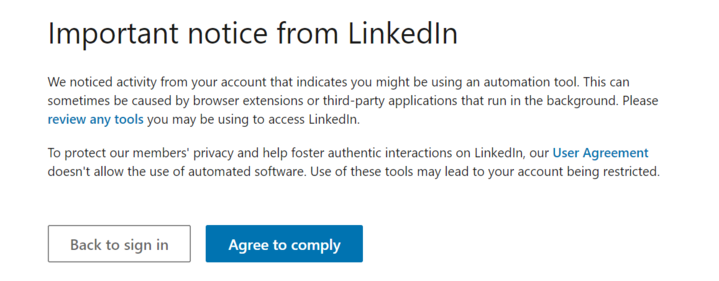

We note and understand that scraping websites like LinkedIn is against their terms of service. Websites like LinkedIn have strict policies and protections in place to prevent unauthorized scraping of their data. This is not only to protect the privacy and data of their users but also to maintain the integrity and security of their services. Hence we will look for other means to get more data. 

At this point, we manage to get 100 posts - which was saved as `presampled_100_linkedin_data.csv`.

In [2]:
# Read the original dataset (taken from Linkedin)
df_linkedin = pd.read_csv("./raw_data/presampled_100_linkedin_data.csv")

In [3]:
# Check info of the data
df_linkedin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_title  101 non-null    object
 1   post       101 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [4]:
df_linkedin.head()

,job_title,post
0,accountant,In my impactful career journey within the bank...
1,accountant,My cheerful personality and easy-going nature ...
2,accountant,As a self-directed learner with my personal be...
3,accountant,I was also honored enough to be the student am...
4,accountant,"Detail-oriented, efficient and organized profe..."


In [5]:
# Check for missing values
df_linkedin.isnull().sum()

job_title    0
post         0
dtype: int64

**Summary:**

This section is to show that we manually scrapped 100 posts from LinkedIn and manage to successfully import the csv in and check for no null values.

---

#### Part 2: Increasing Sample Size

Using the following formula,

$$
{\text{margin of error}} = \frac{\text{1}}{\sqrt{sample size}}
$$

our current sample size of n = 101 will give us an approximate error of 0.10 ([Source](https://towardsdatascience.com/how-big-should-your-sample-size-be-54ab2154c152)). 


To further increase the sample size of LinkedIn posts with job titles, we created synthetic data for a total for 10 job titles to populate the recommender system.
This is created by forming 100 drivers, permuted with 20 base sentences specific to the 10 chosen job titles. Top 50 unique values are taken for each job title.

In [1]:
# Creating a function where we create 50 drivers and match it to base sentences
# To create combinations to see if we get enough unique sentence

def generate_unique_posts(job_title):
    base_sentences = [
        f"{job_title}s play a crucial role in {random.choice(['shaping project outcomes', 'leading technological innovations', 'driving data-driven decisions', 'ensuring software excellence', 'safeguarding digital information', 'inspiring educational growth', 'managing financial integrity', 'enhancing business strategies', 'communicating corporate values'])}.",
        f"My day-to-day tasks involve {random.choice(['coordinating diverse teams', 'architecting scalable solutions', 'applying machine learning techniques', 'analyzing complex datasets', 'writing and optimizing code', 'implementing security measures', 'teaching with passion and creativity', 'preparing accurate financial reports', 'auditing financial operations', 'developing sales strategies', 'crafting marketing campaigns', 'leading corporate communication efforts'])}.",
        f"I'm passionate about {random.choice(['overcoming project challenges', 'solving complex technical problems', 'unlocking insights from data', 'coding innovative software', 'protecting against cyber threats', 'educating the next generation', 'ensuring financial accuracy', 'boosting sales performance', 'creating impactful marketing', 'communicating effectively'])}.",
        f"My professional values include {random.choice(['team collaboration', 'technical excellence', 'data integrity', 'code quality', 'information security', 'educational innovation', 'financial transparency', 'sales ethics', 'marketing creativity', 'communication clarity'])}.",
        f"I enjoy solving problems related to {random.choice(['project deadlines', 'software architecture', 'machine learning applications', 'data analysis', 'programming challenges', 'cybersecurity threats', 'educational methods', 'financial compliance', 'sales goals', 'marketing strategies', 'corporate messaging'])}."
    ]
    
    drivers = [
        "the challenge of new problems",
        "the satisfaction of client success",
        "the continuous learning process",
        "the impact of technological advancements",
        "the joy of innovation",
        "the thrill of solving complex issues",
        "making a tangible difference",
        "the pursuit of excellence",
        "empowering teams to succeed",
        "the evolution of technology",
        "the excitement of discovery",
        "contributing to meaningful projects",
        "the creativity involved in my work",
        "building solutions that matter",
        "the collaboration with talented professionals",
        "the dynamism of the tech landscape",
        "the opportunity to mentor others",
        "the drive for efficiency and effectiveness",
        "creating impactful change",
        "the process of learning from challenges",
        "the ability to shape the future",
        "engaging with diverse perspectives",
        "the dedication to quality",
        "fostering innovation and creativity",
        "the commitment to sustainable solutions",
        "navigating through uncertainty with resilience",
        "the passion for technology and its potential",
        "driving positive change in my field",
        "the fulfillment from teaching and guiding",
        "the curiosity that leads to breakthroughs",
        "the ambition to lead and inspire",
        "the vision for a better future",
        "embracing challenges with courage",
        "the quest for knowledge and understanding",
        "the pride in achieving excellence",
        "the motivation to tackle difficult issues",
        "the eagerness to explore new solutions",
        "the inspiration from success and failure alike",
        "the commitment to personal and professional growth",
        "the determination to overcome obstacles",
        "the enthusiasm for creative problem-solving",
        "the gratification from helping others succeed",
        "the zest for life and its challenges",
        "the keenness to innovate and disrupt",
        "the aspiration to make a significant impact",
        "the dedication to my craft and profession",
        "the spirit of collaboration and teamwork",
        "the resolve to maintain integrity and ethics",
        "the desire to contribute to societal progress"
    ]

    random.shuffle(base_sentences)
    random.shuffle(drivers)

    unique_posts = []
    for i in range(50):
        post = f"{i+1}. As a {job_title}, {base_sentences[i % len(base_sentences)]} What drives me is {drivers[i]}."
        unique_posts.append(post)

    return unique_posts

In [2]:
# Same function, but increasing combinations to 100
# This is because 50 combinations was insufficient to generate unique sentences

def generate_unique_posts(job_title):
    base_sentences = [
        f"{job_title}s play a crucial role in {random.choice(['shaping project outcomes', 'leading technological innovations', 'driving data-driven decisions', 'ensuring software excellence', 'safeguarding digital information', 'inspiring educational growth', 'managing financial integrity', 'enhancing business strategies', 'communicating corporate values'])}.",
        f"My day-to-day tasks involve {random.choice(['coordinating diverse teams', 'architecting scalable solutions', 'applying machine learning techniques', 'analyzing complex datasets', 'writing and optimizing code', 'implementing security measures', 'teaching with passion and creativity', 'preparing accurate financial reports', 'auditing financial operations', 'developing sales strategies', 'crafting marketing campaigns', 'leading corporate communication efforts'])}.",
        f"I'm passionate about {random.choice(['overcoming project challenges', 'solving complex technical problems', 'unlocking insights from data', 'coding innovative software', 'protecting against cyber threats', 'educating the next generation', 'ensuring financial accuracy', 'boosting sales performance', 'creating impactful marketing', 'communicating effectively'])}.",
        f"My professional values include {random.choice(['team collaboration', 'technical excellence', 'data integrity', 'code quality', 'information security', 'educational innovation', 'financial transparency', 'sales ethics', 'marketing creativity', 'communication clarity'])}.",
        f"I enjoy solving problems related to {random.choice(['project deadlines', 'software architecture', 'machine learning applications', 'data analysis', 'programming challenges', 'cybersecurity threats', 'educational methods', 'financial compliance', 'sales goals', 'marketing strategies', 'corporate messaging'])}."
    ]
    
    drivers = [
    "the challenge of new problems",
    "the satisfaction of client success",
    "the continuous learning process",
    "the impact of technological advancements",
    "the joy of innovation",
    "the thrill of solving complex issues",
    "making a tangible difference",
    "the pursuit of excellence",
    "empowering teams to succeed",
    "the evolution of technology",
    "the excitement of discovery",
    "contributing to meaningful projects",
    "the creativity involved in my work",
    "building solutions that matter",
    "the collaboration with talented professionals",
    "the dynamism of the tech landscape",
    "the opportunity to mentor others",
    "the drive for efficiency and effectiveness",
    "creating impactful change",
    "the process of learning from challenges",
    "the ability to shape the future",
    "engaging with diverse perspectives",
    "the dedication to quality",
    "fostering innovation and creativity",
    "the commitment to sustainable solutions",
    "navigating through uncertainty with resilience",
    "the passion for technology and its potential",
    "driving positive change in my field",
    "the fulfillment from teaching and guiding",
    "the curiosity that leads to breakthroughs",
    "the ambition to lead and inspire",
    "the vision for a better future",
    "embracing challenges with courage",
    "the quest for knowledge and understanding",
    "the pride in achieving excellence",
    "the motivation to tackle difficult issues",
    "the eagerness to explore new solutions",
    "the inspiration from success and failure alike",
    "the commitment to personal and professional growth",
    "the determination to overcome obstacles",
    "the enthusiasm for creative problem-solving",
    "the gratification from helping others succeed",
    "the zest for life and its challenges",
    "the keenness to innovate and disrupt",
    "the aspiration to make a significant impact",
    "the dedication to my craft and profession",
    "the spirit of collaboration and teamwork",
    "the resolve to maintain integrity and ethics",
    "the desire to contribute to societal progress",
    "the enjoyment of mastering new skills",
    "the appreciation for meticulous work",
    "the interest in global trends and innovations",
    "the aim to build inclusive and diverse environments",
    "the pleasure of applying theoretical knowledge practically",
    "the drive to push boundaries and question the status quo",
    "the commitment to health and well-being",
    "the ambition to create enduring legacies",
    "the passion for artistic expression",
    "the motivation to bridge gaps between disciplines",
    "the joy of connecting with people",
    "the desire for balance and harmony",
    "the enthusiasm for challenging conventions",
    "the yearning to explore unknown territories",
    "the commitment to environmental stewardship",
    "the drive to optimize and streamline",
    "the pursuit of intellectual challenges",
    "the dedication to fairness and justice",
    "the passion for precision and accuracy",
    "the aim to nurture and develop talent",
    "the determination to solve societal issues",
    "the pleasure of designing aesthetically pleasing solutions",
    "the quest to understand complex systems",
    "the ambition to reduce inefficiencies",
    "the motivation to advocate for change",
    "the joy in sharing knowledge and insights",
    "the desire to lead with empathy and understanding",
    "the enthusiasm for data-driven decisions",
    "the commitment to excellence in craftsmanship",
    "the aspiration to foster peace and understanding",
    "the dedication to supporting community growth",
    "the passion for sustainable living",
    "the motivation to explore scientific mysteries",
    "the interest in enhancing user experiences",
    "the drive for personal fulfillment and happiness",
    "the ambition to inspire through leadership",
    "the commitment to cultural preservation",
    "the determination to innovate for health and safety",
    "the pleasure of solving puzzles and riddles",
    "the quest for artistic mastery",
    "the desire to make informed decisions",
    "the enthusiasm for harnessing renewable energy",
    "the joy of contributing to a team's success",
    "the aim to improve quality of life through technology" # extended list to 100 drivers
]

    # Check and adjust the size of drivers list to exactly 50 items to match the iteration
    if len(drivers) < 50:
        extra_drivers_needed = 50 - len(drivers)
        drivers += drivers[:extra_drivers_needed]  # Duplicate some drivers if needed
    random.shuffle(drivers)

    unique_posts = []
    for i in range(50):
        base_sentence = random.choice(base_sentences)  # Randomly choose a base sentence
        driver = drivers[i]  # Safely pick a driver using index i
        post = f"{i+1}. As a {job_title}, {base_sentence} What drives me is {driver}."
        unique_posts.append(post)

    return unique_posts

In [3]:
# Test to see unique sentence produced

job_title = 'Software Architect'  # Example job title
unique_posts_example = generate_unique_posts(job_title)[:5]  # Generating and showing first 5 unique posts
for post in unique_posts_example:
    print(post)

1. As a Software Architect, I enjoy solving problems related to machine learning applications. What drives me is the motivation to advocate for change.
2. As a Software Architect, I enjoy solving problems related to machine learning applications. What drives me is the spirit of collaboration and teamwork.
3. As a Software Architect, My professional values include information security. What drives me is the opportunity to mentor others.
4. As a Software Architect, I enjoy solving problems related to machine learning applications. What drives me is the process of learning from challenges.
5. As a Software Architect, I'm passionate about unlocking insights from data. What drives me is building solutions that matter.


Based on the above code, we manage to get unique sentences for the job title. However moving forward, we will remove the first part of the sentence where the job title is shown i.e. "As a Software Architect"

We will proceed to create a larger dataset. In essence there are 3 components to creating a sentence -  `job title`, `base sentence` and `drivers`. Hence we proceeded to synthetically create unique sentence by joining a base sentence to a driver. For each job title, we have 20 different base sentences.

In [4]:
# Define base sentences for each job title
base_sentences = {
    "Software Architect": [
    "My professional values include technical excellence.",
    "I'm passionate about coding innovative software.",
    "I enjoy solving problems related to educational methods.",
    "Software Architects play a crucial role in managing financial integrity.",
    "Crafting scalable and resilient systems is what drives me.",
    "I'm dedicated to the pursuit of architecting efficient software solutions.",
    "Integrating new technologies into existing systems excites me.",
    "Designing software that improves user experiences is my goal.",
    "I thrive on creating systems that are not only functional but also secure.",
    "My work is about building the foundation that others can build upon.",
    "Designing systems that efficiently handle massive scale excites me.",
    "My aim is to create software architectures that are both innovative and practical.",
    "I believe in the power of microservices to revolutionize software development.",
    "Ensuring system architectures are future-proof and adaptable is a priority.",
    "Architecting cloud-native solutions is where I find my passion.",
    "I focus on the seamless integration of security practices into software design.",
    "Building resilient systems that withstand failures drives my architectural decisions.",
    "I advocate for the use of open-source technologies in software architecture.",
    "My philosophy is that good architecture simplifies complexity.",
    "I'm intrigued by the challenge of reducing system latency and increasing performance.",
    "Crafting architectures that support continuous integration and delivery is essential.",
    "I'm committed to designing systems that are user-centric and deliver exceptional experiences.",
    "The convergence of AI and software architecture is a field I'm exploring deeply.",
    "I prioritize sustainability and efficiency in software design.",
    "Balancing technical debt with rapid innovation is a challenge I navigate daily.",
    "My approach to software architecture emphasizes collaboration and cross-disciplinary understanding.",
    "I explore new architectural patterns to stay at the forefront of technology.",
    "Ensuring scalability from the start is how I approach every project.",
    "I view software architecture as a blend of art and science.",
    "My work aims to bridge the gap between complex business needs and technical solutions."
],
    "Project Manager": [
    "Leading projects to successful completion with a focus on time, budget, and quality is my expertise.",
    "I excel in coordinating cross-functional teams to achieve project goals and exceed expectations.",
    "My approach to project management is rooted in clear communication and effective stakeholder engagement.",
    "I am passionate about utilizing agile methodologies to enhance project flexibility and deliver value.",
    "Driving the resolution of project issues and risks to ensure smooth project execution is what I do best.",
    "I thrive on building and maintaining strong relationships with clients and team members alike.",
    "My commitment to continuous improvement drives me to seek out lessons learned and apply them to future projects.",
    "I specialize in managing complex projects that require innovative solutions and strategic thinking.",
    "Delivering projects that meet both customer needs and business objectives is my primary goal.",
    "I am adept at navigating the challenges of remote and distributed project teams.",
    "Creating detailed project plans that align with business goals and timelines is a critical part of my role.",
    "I focus on developing project scopes and objectives, involving all relevant stakeholders and ensuring technical feasibility.",
    "My ability to manage changes to project scope, schedule, and costs keeps projects on track.",
    "I use performance measurement tools to monitor project progress and adjust as needed.",
    "Engaging in risk management to minimize project risks and prepare contingency plans.",
    "I ensure resource availability and allocation to keep projects moving forward efficiently.",
    "My leadership fosters a collaborative project environment that encourages input and participation from all team members.",
    "I maintain comprehensive project documentation to ensure accountability and transparency.",
    "Negotiating contracts with vendors and suppliers to secure essential project resources at favorable terms.",
    "I champion the principles of project management within organizations to foster a culture of excellence and efficiency."
],
    "Machine Learning Engineer": [
    "Developing cutting-edge machine learning models to solve industry challenges is my passion.",
    "I specialize in applying deep learning techniques to enhance predictive modeling and analysis.",
    "My work focuses on automating data processing and model training to improve efficiency.",
    "I am committed to advancing AI research to unlock new capabilities and applications.",
    "Collaborating with data scientists and engineers to integrate machine learning into product development.",
    "I utilize a variety of machine learning algorithms to address specific business needs and objectives.",
    "Ensuring the ethical use of AI and advocating for transparency in machine learning models.",
    "I am skilled at optimizing machine learning models for performance in real-world applications.",
    "My approach includes continuous testing and validation to ensure model accuracy and reliability.",
    "I leverage big data technologies to process and analyze large datasets for machine learning.",
    "Exploring novel approaches to machine learning that can drive innovation and competitive advantage.",
    "I focus on feature engineering and selection to improve model outcomes.",
    "Developing custom machine learning algorithms tailored to unique problem sets.",
    "I am passionate about contributing to open-source machine learning projects and communities.",
    "Implementing machine learning solutions that enhance user experiences and engagement.",
    "My work involves close collaboration with stakeholders to define AI project goals and metrics.",
    "I advocate for the responsible and ethical deployment of machine learning technologies.",
    "Staying abreast of the latest trends and advancements in AI and machine learning research.",
    "I specialize in natural language processing and computer vision applications.",
    "Driving the adoption of machine learning across various functions within organizations."
],
    "Data Scientist": [
    "Leveraging data science to extract actionable insights from complex datasets is what I excel at.",
    "I employ advanced statistical analysis and predictive modeling to inform business strategies.",
    "My expertise in data visualization helps stakeholders understand complex data findings.",
    "I am passionate about uncovering trends and patterns through exploratory data analysis.",
    "Developing and deploying machine learning models to solve real-world problems.",
    "I collaborate with interdisciplinary teams to integrate data science into product development.",
    "My work emphasizes the importance of data quality and governance in analytics projects.",
    "I use a variety of data mining techniques to discover hidden insights within data.",
    "Creating scalable data science solutions that drive innovation and value.",
    "I advocate for the use of ethical AI and responsible data science practices.",
    "I focus on automating data analysis processes to enhance decision-making speed and accuracy.",
    "My approach to data science includes rigorous experimentation and hypothesis testing.",
    "I am skilled in managing and analyzing big data using cloud computing platforms.",
    "Developing custom algorithms and models tailored to specific industry needs.",
    "I stay at the cutting edge of data science by continually learning new techniques and tools.",
    "Engaging with business leaders to translate data-driven insights into actionable decisions.",
    "I prioritize the security and privacy of data throughout the analysis process.",
    "Collaborating with data engineers to build robust data pipelines for analytics.",
    "My goal is to make complex data understandable and useful for non-technical audiences.",
    "Leveraging text analytics and sentiment analysis to gain insights from unstructured data."
],
    "Data Analyst": [
    "Transforming complex data sets into clear, actionable insights drives my work.",
    "I specialize in using analytical tools to solve business problems.",
    "My passion lies in uncovering hidden patterns within data to inform strategic decisions.",
    "Ensuring data integrity and accuracy is at the forefront of my analysis.",
    "I leverage data visualization techniques to make data understandable for all stakeholders.",
    "Collaborating with teams to drive improvements based on data-driven insights is what I excel at.",
    "I continuously seek to enhance my analytical skills through ongoing education and challenges.",
    "Developing and refining data models to better predict outcomes is a key part of my role.",
    "I am dedicated to streamlining data collection and analysis processes to increase efficiency.",
    "Utilizing data to tell stories and inspire change is my ultimate goal.",
    "My analyses are aimed at uncovering inefficiencies and optimizing processes.",
    "I employ advanced statistical techniques to predict and model future trends.",
    "Data integrity and meticulous validation underpin every analysis I perform.",
    "I'm passionate about transforming raw data into compelling stories for decision-makers.",
    "Collaborating with data engineers and scientists to refine data collection strategies.",
    "I advocate for data democratization and making insights accessible to non-technical audiences.",
    "My work involves identifying key performance indicators to track and improve business outcomes.",
    "I continuously seek out new data sources to enrich our analyses and insights.",
    "Developing dashboards that provide real-time insights into business metrics.",
    "I specialize in conducting cohort analyses to understand customer behavior over time."
],
    "Computer Programmer": [
    "Crafting efficient, readable code that solves complex problems is my specialty.",
    "I thrive on turning software designs into functional programming.",
    "My dedication lies in continuous code improvement and optimization.",
    "Collaborating with developers and stakeholders to create high-quality software is what motivates me.",
    "I am passionate about learning new programming languages and technologies.",
    "Ensuring scalability and security through code is a critical aspect of my work.",
    "I excel in debugging and fixing issues to enhance software performance and reliability.",
    "My goal is to develop software that improves people's lives and experiences.",
    "I am committed to following best practices in coding and software design.",
    "Automating tasks through clever programming solutions is where I find satisfaction.",
    "I specialize in developing custom algorithms to solve specific problems.",
    "My coding practices emphasize security and data protection from the ground up.",
    "I enjoy automating routine tasks to increase productivity and reduce errors.",
    "Collaborating with UI/UX designers to ensure applications are intuitive and user-friendly.",
    "I'm skilled at optimizing legacy code to improve system performance and reliability.",
    "My work includes contributing to open-source projects and learning from the community.",
    "I focus on cross-platform development to ensure accessibility across devices.",
    "Developing interactive and responsive web applications is my area of expertise.",
    "I'm passionate about exploring new programming paradigms and languages.",
    "My approach to programming is iterative, with a focus on continuous improvement."
],
    "Information Security Analyst": [
    "Protecting information assets from cyber threats is my top priority.",
    "Implementing robust security measures and protocols is the core of my work.",
    "I am constantly updating my knowledge to stay ahead of emerging security trends.",
    "Conducting thorough security audits to identify and mitigate risks is a responsibility I take seriously.",
    "Educating employees on security awareness and best practices is part of my role.",
    "I develop and enforce policies to ensure the safety of digital assets.",
    "Responding to and recovering from security breaches and incidents is where I excel.",
    "I advocate for a proactive approach to information security within the organization.",
    "Collaborating with IT teams to strengthen network security is crucial to my work.",
    "My goal is to create a culture of security mindfulness across all departments.",
    "I focus on proactive threat detection and response to safeguard digital assets.",
    "My strategies include comprehensive risk assessments and mitigation plans.",
    "I'm dedicated to building a security-first culture within organizations.",
    "Developing and implementing disaster recovery and business continuity plans.",
    "I conduct regular security training sessions for employees across departments.",
    "My work involves the ethical hacking and penetration testing of our networks.",
    "I'm passionate about researching and deploying cutting-edge security technologies.",
    "Collaborating with legal teams to ensure compliance with data protection laws.",
    "I advocate for strong encryption practices to protect sensitive information.",
    "Designing security protocols for mobile and IoT devices is a growing focus area."
],
    "Teacher": [
    "Empowering students with knowledge and critical thinking skills is my passion.",
    "I strive to create an inclusive and engaging learning environment for all.",
    "Adapting teaching strategies to meet diverse learner needs is a challenge I embrace.",
    "My commitment to lifelong learning drives me to constantly refine my teaching methods.",
    "I believe in inspiring curiosity and a love of learning in my students.",
    "Assessing student progress and providing constructive feedback is key to their development.",
    "I am dedicated to preparing students for success in and out of the classroom.",
    "Integrating technology into the curriculum to enhance learning experiences is a priority.",
    "Collaborating with parents and colleagues to support student growth is essential.",
    "Fostering a sense of community and respect within the classroom is fundamental to my teaching philosophy.",
    "I integrate real-world applications into lessons to enhance learning relevance.",
    "My teaching methods are designed to foster critical thinking and problem-solving skills.",
    "I prioritize emotional intelligence and social skills alongside academic learning.",
    "Collaborating with colleagues to develop interdisciplinary projects for students.",
    "I'm committed to adapting teaching styles to accommodate diverse learning abilities.",
    "My classroom is a space where mistakes are seen as learning opportunities.",
    "I use technology to create interactive and engaging learning experiences.",
    "Encouraging students to pursue their passions and interests is important to me.",
    "I believe in the power of feedback to guide student growth and improvement.",
    "My goal is to prepare students for success in a rapidly changing world."
],
    "Accountant": [
    "Ensuring financial transactions are accurately recorded and reported is my expertise.",
    "I am committed to upholding the principles of integrity and transparency in accounting.",
    "Analyzing financial statements to provide insights into business performance is what I excel at.",
    "Playing a key role in financial planning and budgeting to support business growth.",
    "Staying abreast of tax laws and regulations to ensure compliance is a critical part of my work.",
    "Leveraging financial data to help make informed strategic decisions.",
    "Streamlining accounting processes through technology is a focus of mine.",
    "I value collaboration with teams across the organization to drive financial efficiency.",
    "My goal is to contribute to the financial health and sustainability of the organization.",
    "Providing financial guidance and support to management and stakeholders is a responsibility I take seriously.",
    "I'm adept at leveraging financial software to streamline accounting processes.",
    "My work ensures that all financial operations comply with regulatory standards.",
    "I'm passionate about providing strategic financial analysis to guide decision-making.",
    "Collaborating with management to develop effective budgeting and financial planning.",
    "Focusing on tax planning and compliance to optimize financial outcomes.",
    "My expertise includes forensic accounting to investigate and resolve discrepancies.",
    "I advocate for financial transparency and accountability within organizations.",
    "Conducting financial audits and reviews to ensure the accuracy of financial reports.",
    "I'm committed to professional development to stay current with accounting standards.",
    "My goal is to enhance financial performance through meticulous analysis and recommendations."
],
    "Auditor": [
    "Conducting financial audits to ensure compliance with laws and regulations is my specialty.",
    "I am dedicated to identifying efficiencies and recommending improvements in financial practices.",
    "My work involves evaluating internal controls to prevent and detect fraud.",
    "Providing independent assurance that an organization's risk management is on the right path motivates me.",
    "I pride myself on my ability to analyze and interpret financial data objectively.",
    "Building trust through transparency and accountability in financial reporting is important to me.",
    "I stay current with auditing standards and practices to deliver high-quality audits.",
    "Collaborating with clients to understand their business and financial risks is a key aspect of my role.",
    "My analytical skills are crucial in identifying discrepancies and anomalies in financial statements.",
    "I aim to add value by providing insights and recommendations that enhance business operations.",
    "My audits are designed to enhance operational efficiency and effectiveness.",
    "I'm skilled at identifying financial risks and recommending controls to mitigate them.",
    "My work fosters trust among stakeholders through rigorous independent assessments.",
    "Collaborating with audit committees to ensure comprehensive governance and oversight.",
    "I'm passionate about promoting ethical business practices through diligent auditing.",
    "Conducting environmental and sustainability audits to assess corporate responsibility.",
    "I advocate for the integration of technology to improve audit accuracy and insights.",
    "Developing audit strategies that align with organizational objectives and risks.",
    "I'm committed to upholding the integrity of financial reporting and audit standards.",
    "My goal is to provide actionable insights to enhance business processes and controls."
],
    "Sales Manager": [
    "Driving sales growth through strategic planning and team leadership is my forte.",
    "I excel in developing and executing sales strategies that meet and exceed targets.",
    "Building and maintaining strong customer relationships is at the heart of my role.",
    "I am passionate about coaching and motivating sales teams to achieve their best.",
    "Analyzing market trends to identify new sales opportunities is crucial to staying competitive.",
    "I leverage data to inform sales tactics and improve team performance.",
    "Negotiating deals and contracts to maximize profitability is a skill I pride myself on.",
    "Creating a dynamic and supportive sales culture is important to me.",
    "I am committed to continuous improvement and innovation in the sales process.",
    "My goal is to drive the company's revenue while ensuring customer satisfaction.",
    "I excel in identifying and developing new sales territories and opportunities.",
    "My leadership style focuses on empowering sales teams to exceed their targets.",
    "I'm passionate about building strong customer relationships to drive repeat business.",
    "Collaborating with marketing to align sales strategies with broader company goals.",
    "I use data-driven insights to refine sales tactics and boost performance.",
    "My approach to sales management emphasizes adaptability and innovation.",
    "I believe in creating a sales culture that values integrity and customer service.",
    "Developing and implementing sales training programs to enhance team skills.",
    "I'm committed to optimizing sales processes for efficiency and effectiveness.",
    "My goal is to lead by example, demonstrating dedication and drive to my team."
],
"Marketing Executive": [
    "Crafting and implementing marketing strategies that drive brand awareness and engagement is what I do.",
    "I thrive on creating content that resonates with our target audience and inspires action.",
    "Analyzing consumer behavior and market trends to inform marketing decisions is a key part of my role.",
    "I am passionate about leveraging digital marketing tools and platforms to reach and engage audiences.",
    "Collaborating with cross-functional teams to launch integrated marketing campaigns excites me.",
    "My focus is on measuring and optimizing marketing performance to ensure ROI.",
    "I believe in building strong brand identities that connect with consumers on a deep level.",
    "Developing and managing marketing budgets to maximize impact is something I excel at.",
    "I am committed to staying ahead of the curve in marketing innovations and best practices.",
    "Engaging with customers through social media and other channels to build community and loyalty is important to me.",
    "I thrive on developing brand strategies that resonate with diverse audiences.",
    "My expertise in digital marketing drives engagement and conversion across platforms.",
    "I'm passionate about leveraging analytics to refine and optimize marketing campaigns.",
    "Collaborating with sales teams to ensure marketing strategies support sales objectives.",
    "I believe in the power of content marketing to tell stories that captivate and convince.",
    "My work includes managing marketing budgets to maximize return on investment.",
    "Developing targeted marketing campaigns that speak directly to the needs of our audience.",
    "I'm committed to staying ahead of trends to keep our marketing strategies fresh and relevant.",
    "My goal is to build a strong, recognizable brand that stands out in a crowded market.",
    "I specialize in creating integrated marketing communications plans that deliver consistent messages."
],
    "Corporate Communications": [
    "I specialize in crafting and delivering clear, compelling corporate messages.",
    "Developing communication strategies that align with corporate goals and values is my expertise.",
    "I am dedicated to managing the company's reputation and brand image through strategic communications.",
    "Building and maintaining relationships with media and stakeholders is a key aspect of my role.",
    "I thrive on creating content that effectively communicates our corporate narrative.",
    "My work involves monitoring and responding to developments that affect corporate reputation.",
    "I leverage various communication channels to reach and engage diverse audiences.",
    "Ensuring internal communications are effective and cohesive is a priority for me.",
    "I am passionate about using communications to drive positive change and corporate social responsibility.",
    "Coordinating with leadership to manage crisis communications and protect the company's interests is something I handle with care.",
    "My focus is on crafting messages that accurately reflect our corporate identity and values.",
    "I'm skilled at managing crisis communications to protect and enhance our company's reputation.",
    "My work involves facilitating internal communications that keep employees informed and engaged.",
    "Collaborating with leadership to articulate our strategic vision and corporate priorities.",
    "I believe in the power of social media to connect with customers and stakeholders directly.",
    "Developing communication plans that support change management and organizational development.",
    "I'm committed to ensuring our corporate communications are inclusive and accessible to all.",
    "My goal is to establish our company as a thought leader in our industry.",
    "I specialize in media relations, building strong connections with journalists and outlets.",
    "Collaborating with HR to communicate employer branding and company culture externally."
],
}

# Define a list of 100 unique drivers for motivation
# Taken from previous cell where we generated 100 drivers
drivers = ["the challenge of new problems",
    "the satisfaction of client success",
    "the continuous learning process",
    "the impact of technological advancements",
    "the joy of innovation",
    "the thrill of solving complex issues",
    "making a tangible difference",
    "the pursuit of excellence",
    "empowering teams to succeed",
    "the evolution of technology",
    "the excitement of discovery",
    "contributing to meaningful projects",
    "the creativity involved in my work",
    "building solutions that matter",
    "the collaboration with talented professionals",
    "the dynamism of the tech landscape",
    "the opportunity to mentor others",
    "the drive for efficiency and effectiveness",
    "creating impactful change",
    "the process of learning from challenges",
    "the ability to shape the future",
    "engaging with diverse perspectives",
    "the dedication to quality",
    "fostering innovation and creativity",
    "the commitment to sustainable solutions",
    "navigating through uncertainty with resilience",
    "the passion for technology and its potential",
    "driving positive change in my field",
    "the fulfillment from teaching and guiding",
    "the curiosity that leads to breakthroughs",
    "the ambition to lead and inspire",
    "the vision for a better future",
    "embracing challenges with courage",
    "the quest for knowledge and understanding",
    "the pride in achieving excellence",
    "the motivation to tackle difficult issues",
    "the eagerness to explore new solutions",
    "the inspiration from success and failure alike",
    "the commitment to personal and professional growth",
    "the determination to overcome obstacles",
    "the enthusiasm for creative problem-solving",
    "the gratification from helping others succeed",
    "the zest for life and its challenges",
    "the keenness to innovate and disrupt",
    "the aspiration to make a significant impact",
    "the dedication to my craft and profession",
    "the spirit of collaboration and teamwork",
    "the resolve to maintain integrity and ethics",
    "the desire to contribute to societal progress",
    "the enjoyment of mastering new skills",
    "the appreciation for meticulous work",
    "the interest in global trends and innovations",
    "the aim to build inclusive and diverse environments",
    "the pleasure of applying theoretical knowledge practically",
    "the drive to push boundaries and question the status quo",
    "the commitment to health and well-being",
    "the ambition to create enduring legacies",
    "the passion for artistic expression",
    "the motivation to bridge gaps between disciplines",
    "the joy of connecting with people",
    "the desire for balance and harmony",
    "the enthusiasm for challenging conventions",
    "the yearning to explore unknown territories",
    "the commitment to environmental stewardship",
    "the drive to optimize and streamline",
    "the pursuit of intellectual challenges",
    "the dedication to fairness and justice",
    "the passion for precision and accuracy",
    "the aim to nurture and develop talent",
    "the determination to solve societal issues",
    "the pleasure of designing aesthetically pleasing solutions",
    "the quest to understand complex systems",
    "the ambition to reduce inefficiencies",
    "the motivation to advocate for change",
    "the joy in sharing knowledge and insights",
    "the desire to lead with empathy and understanding",
    "the enthusiasm for data-driven decisions",
    "the commitment to excellence in craftsmanship",
    "the aspiration to foster peace and understanding",
    "the dedication to supporting community growth",
    "the passion for sustainable living",
    "the motivation to explore scientific mysteries",
    "the interest in enhancing user experiences",
    "the drive for personal fulfillment and happiness",
    "the ambition to inspire through leadership",
    "the commitment to cultural preservation",
    "the determination to innovate for health and safety",
    "the pleasure of solving puzzles and riddles",
    "the quest for artistic mastery",
    "the desire to make informed decisions",
    "the enthusiasm for harnessing renewable energy",
    "the joy of contributing to a team's success",
    "the aim to improve quality of life through technology"
]


# Create function to randomly create 50 sentences per job title
# In total we will have 500 synthetically created sentences (10 job titles * 50 rows)
def generate_unique_posts_for_job_title(job_title, drivers, base_sentences):
    unique_posts = []
    random_drivers = random.sample(drivers, 50)  # Ensure unique drivers for each post
    for i in range(50):
        base_sentence = random.choice(base_sentences[job_title])
        driver = random_drivers[i]
        post = f"{base_sentence} What drives me is {driver}."
        unique_posts.append(post)
    return unique_posts


# Create function to put the 500 sentences into the csv file
# Format of csv file: "job title" (column 1), "posts" - base sentence + driver (column 2) - Resulting csv file will only have 2 columns
def compile_posts_to_csv(job_titles, drivers, base_sentences, filename="syn_job_posts.csv"):
    all_posts = []
    for job_title in job_titles:
        posts = generate_unique_posts_for_job_title(job_title, drivers, base_sentences)
        for post in posts:
            all_posts.append([job_title, post])

    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Job Title", "Corresponding Post"])  # Header with specified column names
        writer.writerows(all_posts)

# Example usage with a list of job titles
job_titles = ["Software Architect", "Data Analyst", "Computer Programmer", "Information Security Analyst", "Teacher", "Accountant", "Auditor", "Sales Manager", "Marketing Executive", "Corporate Communications"]


# Generate and compile posts into a CSV file
compile_posts_to_csv(job_titles, drivers, base_sentences)

In [5]:
# Path to the csv file
csv_filename = "syn_job_posts.csv"

# Open the csv file and read the first 10 rows
with open(csv_filename, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    # Read the header
    header = next(reader)
    print(header)  # Print the header
    # Initialize a counter to keep track of rows
    row_count = 0
    # Iterate over the rows in the CSV
    for row in reader:
        print(row)  # Print the current row
        row_count += 1
        if row_count == 10:  # Stop after printing 10 rows
            break

['Job Title', 'Corresponding Post']
['Software Architect', 'My approach to software architecture emphasizes collaboration and cross-disciplinary understanding. What drives me is the enjoyment of mastering new skills.']
['Software Architect', 'Balancing technical debt with rapid innovation is a challenge I navigate daily. What drives me is the pleasure of designing aesthetically pleasing solutions.']
['Software Architect', 'I advocate for the use of open-source technologies in software architecture. What drives me is the motivation to tackle difficult issues.']
['Software Architect', 'My philosophy is that good architecture simplifies complexity. What drives me is the aspiration to foster peace and understanding.']
['Software Architect', 'Crafting scalable and resilient systems is what drives me. What drives me is the spirit of collaboration and teamwork.']
['Software Architect', 'My professional values include technical excellence. What drives me is the opportunity to mentor others.']


---

###  Part 3: Exploring the Linkedin Job Role Distribution

After generating 500 rows of synthetic data, we will combine it with the 100 rows that we scrapped from Linkedin to give us a new csv file that consists of 600 rows of data. We will import the csv in for part 3 to look at the job role distribution and balance it out.

In [6]:
# Read the full dataset (600 rows) from LinkedIn
df_linkedin_600 = pd.read_csv("./raw_data/jobs_posts_600.csv")

In [7]:
# Check first 5 rows
df_linkedin_600.head()

,job_title,post
0,Software Architect,The convergence of AI and software architectur...
1,Software Architect,Ensuring scalability from the start is how I a...
2,Software Architect,I thrive on creating systems that are not only...
3,Software Architect,Crafting architectures that support continuous...
4,Software Architect,Building resilient systems that withstand fail...


In [8]:
# Find unique titles
df_linkedin_600["job_title"].unique()

array(['Software Architect', 'Data Analyst', 'Computer Programmer',
       'Information Security Analyst', 'Teacher', 'Accountant', 'Auditor',
       'Sales Manager', 'Marketing Executive', 'Corporate Communications',
       'Data Scientist', 'Software Engineer'], dtype=object)

In [9]:
# Check for total data for this combined df - should be 600 rows
df_linkedin_600.shape

(601, 2)

In [10]:
# relabel and recategorize the job titles
regrouped_values = {"Accountant": "acc",
                    "Auditor": "aud",
                    "Computer Programmer": "cp",
                    "Corporate Communications": "cc",
                    "Data Analyst": "da",
                    "Data Scientist": "ds",
                    "Information Security Analyst": "isa",
                    "Marketing Executive": "me",
                    "Sales Manager": "sm",
                    "Software Architect": "sa",
                    "Software Engineer": "se",
                    "Teacher": "tea"
                    }

df_linkedin_600 = df_linkedin_600.replace({"job_title": regrouped_values})

# see updated categories of job titles
df_linkedin_600["job_title"].unique()

array(['sa', 'da', 'cp', 'isa', 'tea', 'acc', 'aud', 'sm', 'me', 'cc',
       'ds', 'se'], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

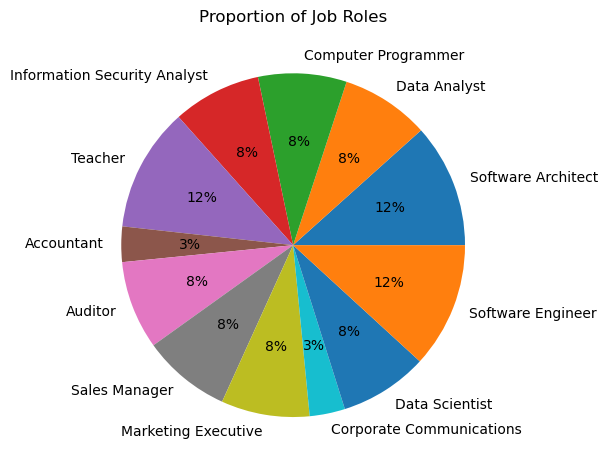

In [11]:
# Plot to see the proportion of job titles 

data = df_linkedin_600.groupby("job_title")["job_title"].value_counts() 
key = ["Software Architect", "Data Analyst", "Computer Programmer",
       "Information Security Analyst", "Teacher", "Accountant", "Auditor",
       "Sales Manager", "Marketing Executive", "Corporate Communications",
       "Data Scientist", "Software Engineer"]

plt.pie(data, labels = key, autopct = "%.0f%%")
plt.title("Proportion of Job Roles")
plt.tight_layout()
plt.show

In [9]:
# Check the actual value counts of each category
df_linkedin_600["job_title"].value_counts()

job_title
tea    71
da     70
acc    70
sa     50
cp     50
isa    50
aud    50
sm     50
me     50
cc     50
ds     20
se     20
Name: count, dtype: int64

In [13]:
# Downsample all categories except ds and de for balanced classes

# Count the number of samples for each class
type_counts = df_linkedin_600["job_title"].value_counts()

# Set the sample size we want for each class
class_size = 20

# Balance the dataset by downsampling
# Instantiate an empty dataframe respectively 
df_balanced_jobs = pd.DataFrame()

for job in type_counts.index:
    job_subset_down = df_linkedin_600[df_linkedin_600["job_title"] == job]
    downsampled_subset = resample(job_subset_down,
                                  replace = False,  # Downsample without replacement
                                  n_samples = class_size,
                                  random_state = 42) 
    df_balanced_jobs = pd.concat([df_balanced_jobs, downsampled_subset])

**Insights:**

Based on the original distribution of data for each job roles, "Teacher", "Data Analyst" and "Accountant" have the most rows whereas "Data Scientist" and "Software Engineers" have the least. We will want to balance out all the job roles so that they get equal representation when we put the dataset into our recommender system in Notebook 5. We did this by downsampling all job roles to 20 samples each.

<function matplotlib.pyplot.show(close=None, block=None)>

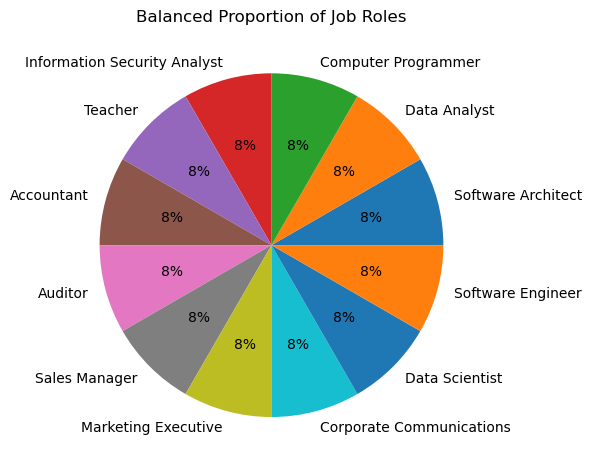

In [14]:
# Recheck plot to see the proportion of job titles

data = df_balanced_jobs.groupby("job_title")["job_title"].value_counts() 
key = ["Software Architect", "Data Analyst", "Computer Programmer",
       "Information Security Analyst", "Teacher", "Accountant", "Auditor",
       "Sales Manager", "Marketing Executive", "Corporate Communications",
       "Data Scientist", "Software Engineer"]

plt.pie(data, labels = key, autopct = "%.0f%%")
plt.title("Balanced Proportion of Job Roles")
plt.tight_layout()
plt.show

In [15]:
# Check shape of balanced dataset
df_balanced_jobs.shape

(240, 2)

---

### Part 4: Saving the upsampled Linkedin dataset into a new CSV file

In [16]:
# save the newly populated dataset into a csv
df_balanced_jobs.to_csv("./raw_data/linkedin_240.csv", index = False)

**Summary:**

Since we manually obtained the data from Linkedin ourselves, there were more control over getting clean data during data collection to reduce the need for data cleaning later. Data type is appropriate as "object" as both are text data. From 100 authentic data points, we synthetically created more data and ultimately picked 240 profiles that are equally distributed across 12 job roles and we saved it as a new csv file which we will use in Notebook 2 for EDA.

---
### Downloading SDV library for synthetic data generation

[Synthetic Data Vault](https://docs.sdv.dev/sdv/)

We attempted this library to see what sythetic results could be generated but we did not use it on our actual data moving forward.

To attempt this section, the libraries in the next cell needs to be installed for the code to run. A separate folder - sdv_testing -  was created to put the raw data file and to contain the resulting csvs from the 2 methods of synthetic data creation. Along with the 2 csvs files at the end to show the resultant synthetically increased dataset, running the code will automatically produce 2 html files in a folder labelled as "iframe_figures". For convenience sake, the images from the 2 html files (which are bar charts to show the proportion of synthetic vs real data) are hard-copied into the notebook.

In [ ]:
#!pip install sdv
#!pip install plotly == 5.10

In [13]:
# Read the original dataset (taken from Linkedin)
df_linkedin_sdv = pd.read_csv("./sdv_testing_data/presampled_linkedin_data_constance.csv")

In [14]:
df_linkedin_sdv = df_linkedin_sdv.reset_index()

In [15]:
# For the following code in 1) and 2) to work, there must be a column created that can be used as an "index"
df_linkedin_sdv.rename(columns = {"index":"number"}, inplace=True)

In [16]:
df_linkedin_sdv.head()

,number,job_title,post
0,0,accountant,My cheerful personality and easy-going nature ...
1,1,accountant,As a self-directed learner with my personal be...
2,2,accountant,I was also honored enough to be the student am...
3,3,accountant,"Detail-oriented, efficient and organized profe..."
4,4,accountant,"Hello, I am a highly motivated individual and ..."


##### Following steps in accordance to website

In [17]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [18]:
metadata.detect_from_dataframe(df_linkedin_sdv)

In [19]:
python_dict = metadata.to_dict()
python_dict

{'columns': {'number': {'sdtype': 'id'},
  'job_title': {'sdtype': 'categorical'},
  'post': {'sdtype': 'unknown', 'pii': True}},
 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'primary_key': 'number'}

In [20]:
metadata.update_column(
    column_name = "post",
    sdtype = "categorical")

In [21]:
metadata.update_column(
    column_name = "job_title",
    sdtype = "categorical")

In [22]:
metadata.set_primary_key(column_name = "number")

c:\Users\Admin\anaconda3\envs\doodlesacer\Lib\site-packages\sdv\metadata\single_table.py:517: UserWarning: There is an existing primary key 'number'. This key will be removed.
  warnings.warn(


In [23]:
metadata.validate_data(data = df_linkedin_sdv)

#### <b> Method 1: Gausssian Coupula Synthesizer </b>

In [26]:
from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df_linkedin_sdv)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows = 200)

In [27]:
synthetic_data.head()

,number,job_title,post
0,0,software_engineer,awesome. want to see how schools are benefitti...
1,1,software_engineer,Solution-driven and passionate software engine...
2,2,software_engineer,"Coding, for me, is more than a skill — it's a ..."
3,3,data_scientist,A lot of people comment on my content wanting ...
4,4,data_analyst,"As a technologist, I naturally possess an apti..."


In [28]:
synthetic_data.to_csv("./sdv_testing_data/syntheticdata_constance.csv", index = False)

In [36]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data = df_linkedin_sdv,
    synthetic_data = synthetic_data,
    metadata = metadata,
    column_name = "job_title"
)
    
fig.show();

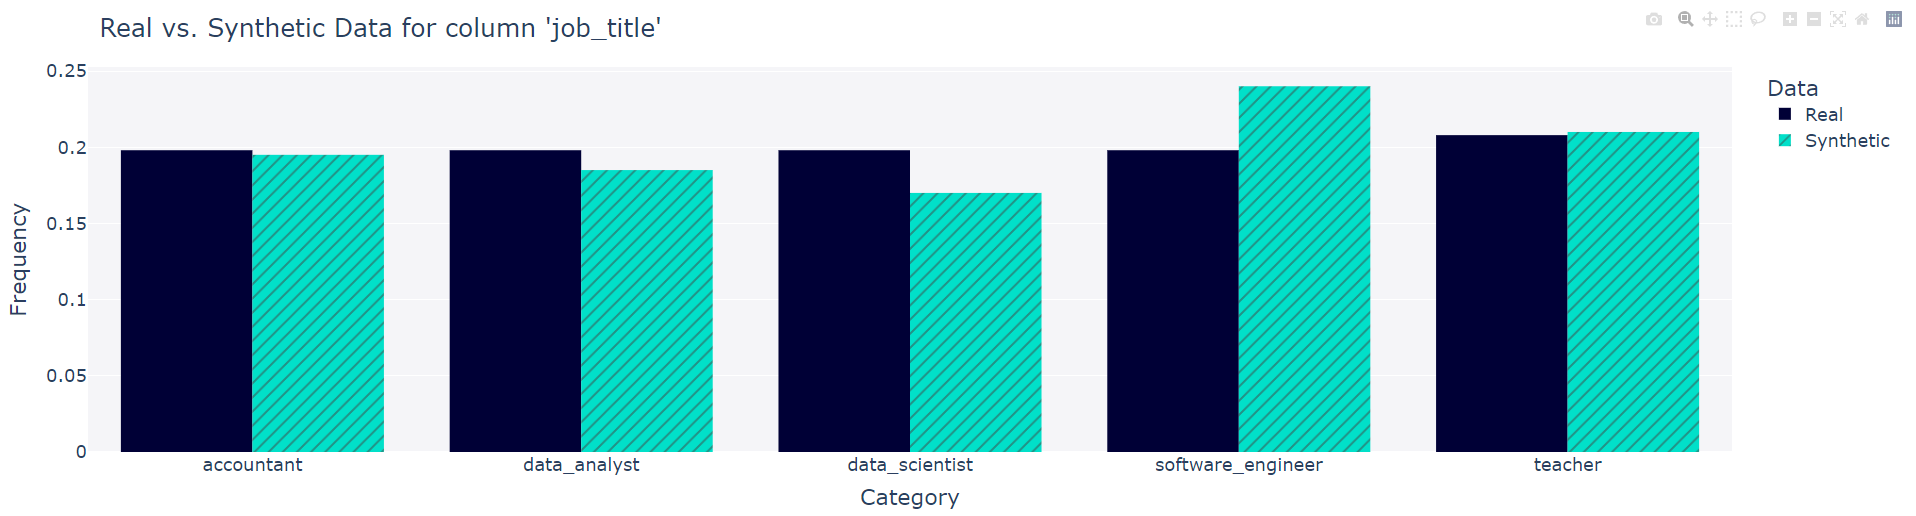

#### <b> Method 2: Fast ML Preset</b>

In [31]:
from sdv.lite import SingleTablePreset

synthesizer2 = SingleTablePreset(metadata, name = "FAST_ML")
synthesizer2.fit(df_linkedin_sdv)

synthetic_data2 = synthesizer2.sample(num_rows = 200)

In [32]:
synthetic_data2

,number,job_title,post
0,0,software_engineer,"""Life is beautiful not because of the things w..."
1,1,software_engineer,Hi everyone - I am looking for a new role and ...
2,2,software_engineer,"Working within a team environment, I embraced ..."
3,3,data_scientist,The American mathematician John Tukey once sai...
4,4,data_analyst,"As a technologist, I naturally possess an apti..."
...,...,...,...
195,195,data_scientist,The American mathematician John Tukey once sai...
196,196,software_engineer,I am currently at Semantics3 as a data scienti...
197,197,data_scientist,Why you need to have the mamba mentality: Kobe...
198,198,teacher,I'm on a mission to educate and fine-tune myse...


In [33]:
synthetic_data2.to_csv("./sdv_testing_data/syntheticdata2_constance.csv", index = False)

In [37]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data = df_linkedin_sdv,
    synthetic_data = synthetic_data2,
    metadata = metadata,
    column_name = "job_title"
)
    
fig.show();

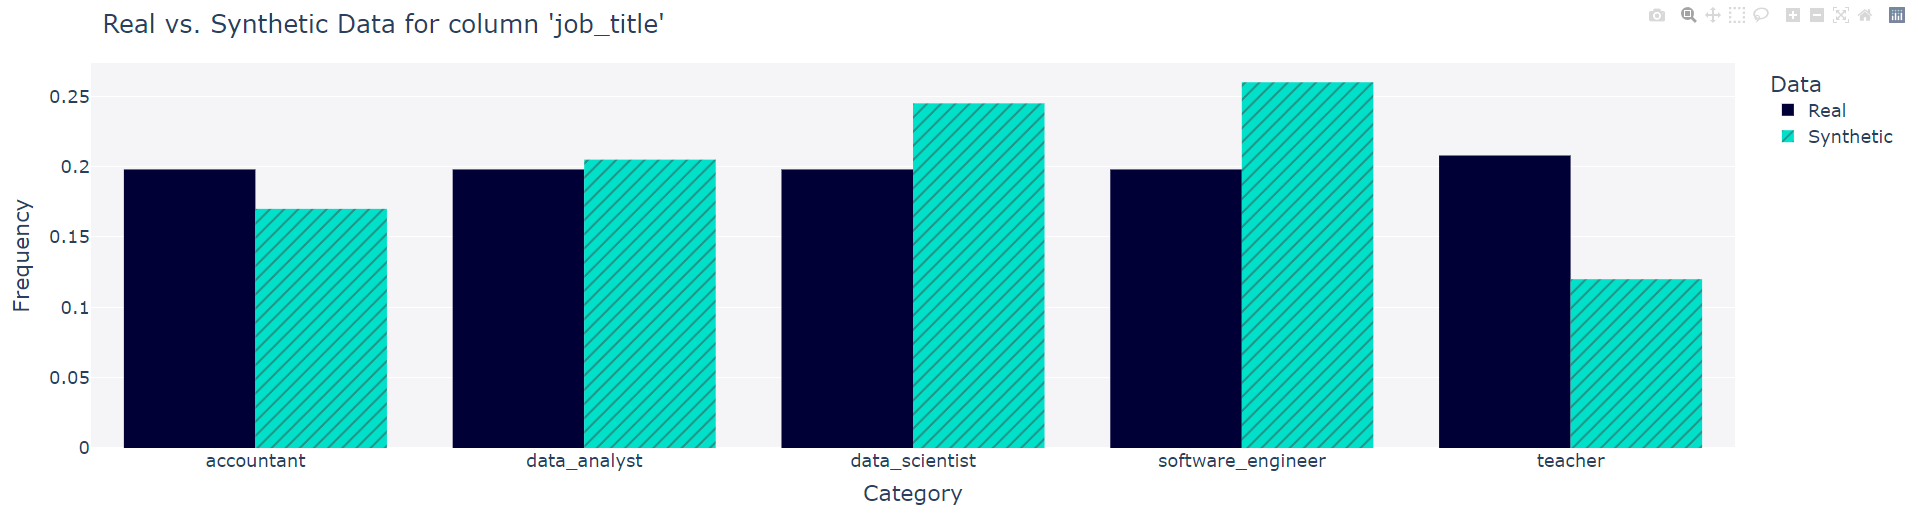